In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import accuracy_score
import xgboost as xgb

# from sklearn.datasets import load_breast_cancer
# from imblearn.over_sampling import SMOTE, RandomOverSampler

In [63]:
GOAL = ['y']
FEATURES = ['age', 'balance','day','duration',
            'campaign','pdays','previous'
           ]
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = ['job','marital','education','default',
                        'housing','loan','contact','month','poutcome','y'
                       ] # features that require pre-processing

over_sampling = False

In [67]:
def run_load_data():
    print ('load_data - START')
    data = pd.read_csv(os.path.join(os.getcwd(), '../data', 'data.csv'), sep=';')
    data.to_csv(os.path.join('../data', file_name), sep=',', index=False)
    print ('load_data - END')
    return data

In [66]:
run_load_data()

load_data - START
load_data - END


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [17]:
def run_train_test_split(data):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [39]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # Fill NULL with Mean / Median / -1
    for f in FEATURES:
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        train_df[f] = imp.fit_transform(train_df[f].values.reshape(-1,1))
        test_df[f] = imp.fit_transform(test_df[f].values.reshape(-1,1))
    
    # Pre-processing non-numeric values using numeric encoding
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    # Encode using .cat.codes or LabelEncoder:
    # http://pbpython.com/categorical-encoding.html
    for f in CATEGORICAL_FEATURES:
        train_df[f] = train_df[f].astype('category').cat.codes
        test_df[f] = test_df[f].astype('category').cat.codes
#         lbl = LabelEncoder()
#         train_df[f] = lbl.fit_transform(train_df[f].reshape(-1,1))
#         test_df[f] = lbl.fit_transform(test_df[f].reshape(-1,1))
    print ('pre_processing - END') 
    return train_df, test_df

In [19]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [20]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [21]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4],
        'n_estimators': [500, 750],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }
    
    gbm = xgb.XGBClassifier()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X_train, y_train.values.ravel()) # Using values.ravel() to change to 1D array - https://stackoverflow.com/questions/42928855/gridsearchcv-error-too-many-indices-in-the-array

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best AUC found: ", grid.best_score_)
    
    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_sub_sample = grid.best_params_["subsample"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"]  
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree

In [22]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"binary:logistic", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "subsample":best_sub_sample,
              "colsample_bytree":best_colsample_bytree
             }
    
    print(dmatrix)
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        stratified=True,
                        num_boost_round=10,
                        metrics="auc",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-auc-mean"].iloc[-1]
    print "cross-validation model accuracy on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')    

In [23]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              subsample=best_sub_sample,
                              colsample_bytree=best_colsample_bytree,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [24]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [25]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = accuracy_score(y_test, prediction)
    print "model accuracy on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END')

In [26]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'max_depth': 3})
('Best AUC found: ', 0.8584536557266802)
grid_search - END
train_model - START


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_model - END
run_prediction - START
run_prediction - END
model_evaluation_on_test - START
model accuracy on test dataset:  0.8983425414364641
model_evaluation_on_test - END
feature_importance - START


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


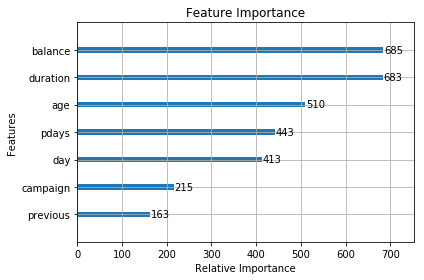

feature_importance - END
('elapsed_time (in seconds): ', 89.50911211967468)


In [44]:
def xgboost_binary_classification():
    start_time = time.time()
    data = run_load_data()
    train_df, test_df = run_train_test_split(data) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree = run_grid_search(X_train, y_train)
# To check accuracy, run either Grid Search or Cross Validation as Cross Validation is already embedded in Grid Search
#     run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_feature_importance(model)
    print('elapsed_time (in seconds): ', time.time() - start_time)
xgboost_binary_classification()